# Projecting terrestrial biodiversity using PREDICTS and LUH2

This notebook shows how to use rasterset to project a PREDICTS model using the LUH2 land-use data.

You can set three parameters below:

- scenario: can be either historical (850CE - 2015CE) or one of he LUH2 scenarios available (all in lowercase, e.g. ssp1_rcp2.6_image).
- year: year for which to generate the projection. For the historical scenario the year must be between 850-2015. For the SSP scenarios the year must be between 2015-2100.
- what: the name of the variable to evaluate. Many abundance models evaluate a variable called *LogAbund*. If you want to project abundance than what should be *LogAbund*. But you can use any of the intermediate variables as well. For example setting what to *hpd* will generate a projection of human population density.

### Imports (non-local)

In [25]:
import click
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio
from rasterio.plot import show, show_hist

### Local imports

In [1]:
from projections.rasterset import RasterSet, Raster
from projections.simpleexpr import SimpleExpr
import projections.r2py.modelr as modelr
import projections.predicts as predicts
import projections.utils as utils


### Parameters

In [20]:
scenario = 'historical'
year = 2000
what = 'LogAbund'

### Models
This notebook uses Sam's LUH2 abundance models. Thus we need to load a forested and a non-forested model, project using both and then combine the projection.


In [21]:
modf = modelr.load('ab-fst-1.rds')
intercept_f = modf.intercept
predicts.predictify(modf)

modn = modelr.load('ab-nfst-1.rds')
intercept_n = modn.intercept
predicts.predictify(modn)

### Rastersets
Use the PREDICTS python module to generate the appropriate *rastersets*. Each rasterset is like a DataFrame or hash (dict in python). The columns are variables and hold a function that describes how to compute the data.

Generating a rasterset is a two-step process. First generate a hash (dict in python) and then pass the dict to the constructor.

Each model will be evaluated only where the forested mask is set (or not set). Load the mask from the LUH2 statis data set.

Note that we need to explicitly assign the R model we loaded in the previous cell to the corresponding variable of the rasterset.

In [22]:
fstnf = rasterio.open(utils.luh2_static('fstnf'))
rastersf = predicts.rasterset('luh2', scenario, year, 'f')
rsf = RasterSet(rastersf, mask=fstnf, maskval=0.0)
rastersn = predicts.rasterset('luh2', scenario, year, 'n')
rsn = RasterSet(rastersn, mask=fstnf, maskval=1.0)
vname = modf.output
assert modf.output == modn.output
rsf[vname] = modf
rsn[vname] = modn


### Eval
Now evaluate each model in turn and then combine the data. Because we are guaranteed that the  data is non-overlaping (no cell should have valid data in both projections) we can simply add them together (with masked values filled in as 0). The overall mask is the logical **AND** of the two invalid masks. 

In [23]:
datan, meta = rsn.eval(what, quiet=True)
dataf, _ = rsf.eval(what, quiet=True)
data_vals = dataf.filled(0) + datan.filled(0)
data = data_vals.view(ma.MaskedArray)
data.mask = np.logical_and(dataf.mask, datan.mask)


### Rendering
Use matplotlib (via rasterio.plot) to render the generated data. This will display the data in-line in the notebook.

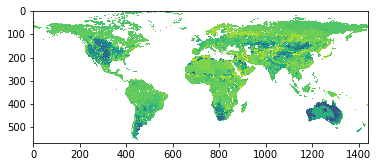

In [24]:
show(data, cmap='viridis')